In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # For better visualization of the confusion matrix
from datetime import datetime
import unittest
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore", message="Truncated File Read")

In [33]:
class Config:
    def __init__(self):
        self.data_path = "PetImages"  # Path to the main data folder
        self.batch_size = 32
        self.image_size = (128, 128)
        self.epochs = 15
        self.learning_rate = 0.001
        self.test_size = 0.2  # 20% of data as the test set
        self.random_state = 42  # Seed for reproducibility
        self.augmentation = {
            "rotation_range": 30,
            "width_shift_range": 0.2,
            "height_shift_range": 0.2,
            "shear_range": 0.2,
            "zoom_range": 0.2,
            "horizontal_flip": True
        }
        self.model_save_path = 'best_model.keras'  # Changed model save path to Keras format
        # Adding TensorBoard logs path with a unique timestamp
        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = os.path.join("logs", current_time)

class DataProcessor:
    def __init__(self, config):
        self.config = config

    def load_data(self):
        classes = ['Cat', 'Dog']
        data = []
        labels = []
        
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(self.config.data_path, class_name)
            if not os.path.isdir(class_dir):
                print(f"Folder {class_dir} does not exist. Skipping class {class_name}.")
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    img = load_img(img_path, target_size=self.config.image_size)
                    img_array = img_to_array(img)
                    data.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Cannot load image {img_path}: {e}")
        
        data = np.array(data, dtype="float32") / 255.0  # Normalization
        labels = np.array(labels)
        
        # Splitting into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, test_size=self.config.test_size, 
            random_state=self.config.random_state, stratify=labels
        )
        
        print(f"Number of training samples: {X_train.shape[0]}")
        print(f"Number of test samples: {X_test.shape[0]}")
        
        return X_train, y_train, X_test, y_test

    def analyze_data(self, X, y, dataset_name="Dataset"):
        print(f"\n--- Data Analysis ---")
        print(f"Shape of data: {X.shape}")
        print(f"Label distribution: {np.bincount(y)}")
        print(f"Mean pixel value: {np.mean(X)}")
        print(f"Standard deviation of pixel values: {np.std(X)}")
        plt.figure(figsize=(10, 6))
        plt.hist(X.flatten(), bins=50, color='blue', alpha=0.7)
        plt.title(f"Pixel Value Distribution - {dataset_name}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.show()

class FeatureEngineer:
    def __init__(self, config):
        self.config = config
        self.augmentor = ImageDataGenerator(**self.config.augmentation)

    def augment_data(self, X_train, y_train):
        # Apply augmentation only to the training set
        augmented_X = []
        augmented_y = []
        for _ in range(self.config.epochs):
            for X_batch, y_batch in self.augmentor.flow(X_train, y_train, batch_size=self.config.batch_size, shuffle=True):
                augmented_X.append(X_batch)
                augmented_y.append(y_batch)
                if len(augmented_X) * self.config.batch_size >= len(X_train):
                    break
        augmented_X = np.vstack(augmented_X)
        augmented_y = np.hstack(augmented_y)
        return augmented_X, augmented_y

class ModelTrainer:
    def __init__(self, config):
        self.config = config
        self.model = None

    def build_model(self):
        self.model = Sequential([
            Input(shape=(*self.config.image_size, 3)),  # Input layer
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Dropout(0.3),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(self.config.learning_rate),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        self.model.summary()  # Display the model architecture

    def train_model(self, X_train, y_train, class_weights=None):
        # Callback to save the best model in Keras format
        checkpoint = ModelCheckpoint(
            self.config.model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
        # TensorBoard callback
        tensorboard_callback = TensorBoard(
            log_dir=self.config.log_dir,
            histogram_freq=1,          # Log histograms every epoch
            write_graph=True,          # Log the graph
            write_images=True,         # Log model weights as images
            update_freq='epoch'        # Update logs every epoch
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=self.config.epochs,
            batch_size=self.config.batch_size,
            class_weight=class_weights,
            callbacks=[checkpoint, tensorboard_callback]  # Adding TensorBoard to the list of callbacks
        )
        return history

    def evaluate_model(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def fine_tune_model(self, X_train, y_train, class_weights=None):
        self.model.layers[-1].trainable = True
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(self.config.learning_rate * 0.1),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        history = self.train_model(X_train, y_train, class_weights)
        return history

test_0_load_images (__main__.UnitTests.test_0_load_images)
Test if all images are loaded correctly. ... ok


Number of training samples: 19956
Number of test samples: 4990
Successfully loaded 24946 images.


test_1_normalization (__main__.UnitTests.test_1_normalization)
Test if normalization is working by displaying a normalized image. ... 

Number of training samples: 19956
Number of test samples: 4990


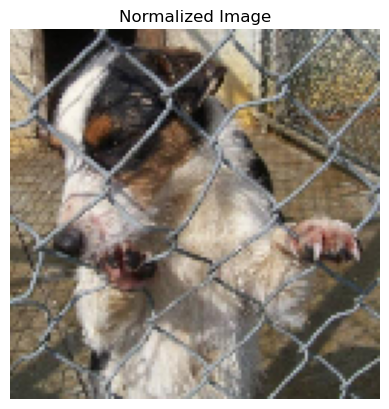

ok
test_2_augmentation (__main__.UnitTests.test_2_augmentation)
Test if data augmentation works by displaying an augmented image. ... 

Number of training samples: 19956
Number of test samples: 4990


C:\Users\Arek\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


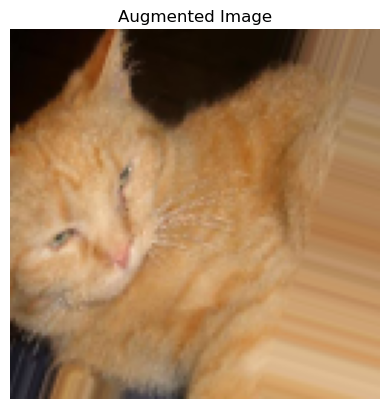

ok

----------------------------------------------------------------------
Ran 3 tests in 226.017s

OK


In [14]:
class UnitTests(unittest.TestCase):
    def setUp(self):
        import warnings
        warnings.filterwarnings("ignore", message="Truncated File Read")
        """Set up the configuration, data processor, and feature engineer for the tests."""
        self.config = Config()
        self.data_processor = DataProcessor(self.config)
        self.feature_engineer = FeatureEngineer(self.config)
        self.X_train, self.y_train, self.X_test, self.y_test = self.data_processor.load_data()

    def test_0_load_images(self):
        """Test if all images are loaded correctly."""
        total_images = len(self.X_train) + len(self.X_test)
        self.assertGreater(total_images, 0, "No images were loaded. Check your dataset path.")
        print(f"Successfully loaded {total_images} images.")

    def test_1_normalization(self):
        """Test if normalization is working by displaying a normalized image."""
        normalized_image = self.X_train[0]
        self.assertTrue(np.all(normalized_image <= 1.0) and np.all(normalized_image >= 0.0),
                        "Normalization failed: pixel values are not in the range [0, 1].")
        plt.imshow(normalized_image)
        plt.title("Normalized Image")
        plt.axis("off")
        plt.show()

    def test_2_augmentation(self):
        """Test if data augmentation works by displaying an augmented image."""
        augmented_X, _ = self.feature_engineer.augment_data(self.X_train, self.y_train)
        augmented_image = augmented_X[0]
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    # Run unit tests
    unittest.main(argv=[''], verbosity=2, exit=False)

Number of training samples: 19956
Number of test samples: 4990

--- Data Analysis ---
Shape of data: (24946, 128, 128, 3)
Label distribution: [12476 12470]
Mean pixel value: 0.45337730646133423
Standard deviation of pixel values: 0.26095208525657654


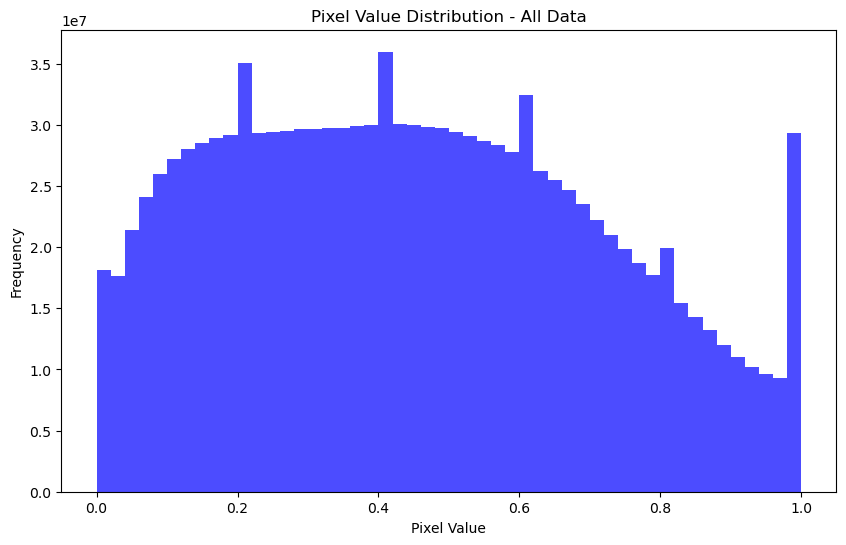

Class weights: {0: 0.9997995991983968, 1: 1.0002004811547716}


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,105 (3.20 MB)

 Trainable params: 839,105 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Main training
Epoch 1/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.5311 - loss: 0.6898 - val_accuracy: 0.5722 - val_loss: 0.6741
Epoch 2/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.5958 - loss: 0.6619 - val_accuracy: 0.6746 - val_loss: 0.6233
Epoch 3/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.6639 - loss: 0.6181 - val_accuracy: 0.6996 - val_loss: 0.6006
Epoch 4/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.6868 - loss: 0.5849 - val_accuracy: 0.7096 - val_loss: 0.5687
Epoch 5/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.7174 - loss: 0.5485 - val_accuracy: 0.7229 - val_loss: 0.5710
Epoch 6/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.7299 - loss: 0.5338 - val_accuracy: 0.7491 - val_loss: 0.5033
Epoch 7/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 59s 116ms/step - accuracy: 0.7520 - loss: 0.5008 - val_accuracy: 0.7442 - val_loss: 0.5165
Epoch 8/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 60s 116ms/step - accuracy: 0.

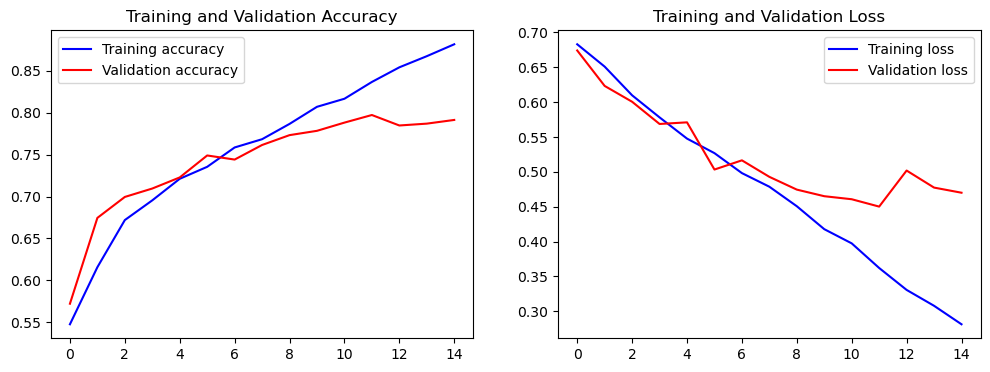

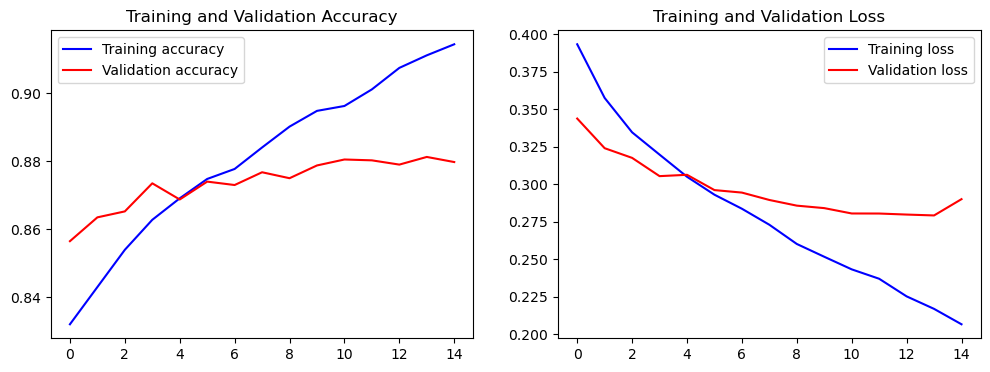

156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


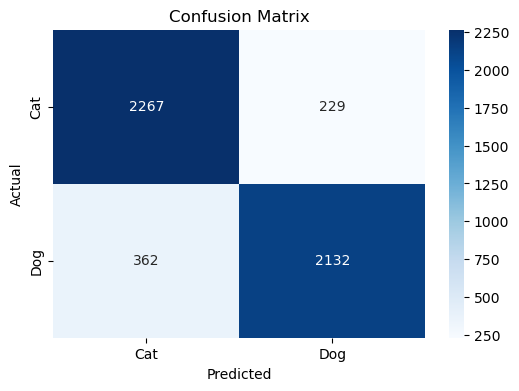

Classification Report:
              precision    recall  f1-score   support

         Cat       0.86      0.91      0.88      2496
         Dog       0.90      0.85      0.88      2494

    accuracy                           0.88      4990
   macro avg       0.88      0.88      0.88      4990
weighted avg       0.88      0.88      0.88      4990



In [34]:
class App:
    def __init__(self):
        self.config = Config()
        self.data_processor = DataProcessor(self.config)
        self.feature_engineer = FeatureEngineer(self.config)
        self.model_trainer = ModelTrainer(self.config)

    def run(self):
        # Check if the data folder exists
        if not os.path.exists(self.config.data_path):
            print(f"Folder {self.config.data_path} does not exist. Please ensure the path is correct.")
            return

        # Load data
        X_train, y_train, X_test, y_test = self.data_processor.load_data()

        # Combine training and test sets for overall data analysis
        X_all = np.concatenate((X_train, X_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)

        # Data analysis for all images together
        self.data_processor.analyze_data(X_all, y_all, "All Data")

        # Feature engineering (augmentation)
        augmented_X_train, augmented_y_train = self.feature_engineer.augment_data(X_train, y_train)

        # Calculating class weights (if necessary)
        class_weights = None
        if len(np.unique(y_train)) > 1:
            class_weights_values = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights = dict(enumerate(class_weights_values))
            print(f"Class weights: {class_weights}")

        # Build the model
        self.model_trainer.build_model()

        # Train the model
        print("Main training")
        history = self.model_trainer.train_model(augmented_X_train, augmented_y_train, class_weights)
        
        # Fine-tuning the model
        print("Fine-tuning")
        history_fine = self.model_trainer.fine_tune_model(X_train, y_train, class_weights)

        # Evaluate the model
        results = self.model_trainer.evaluate_model(X_test, y_test)
        print(f"Model evaluation results: {results}")

        # Visualization of training results
        print("Main training")
        self.plot_history(history)

        # Visualization of training results
        print("Fine-tuning")
        
        self.plot_history(history_fine)

        # Generate confusion matrix and classification report
        self.generate_evaluation_report(X_test, y_test)

    def plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'b', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.show()

    def generate_evaluation_report(self, X_test, y_test):
        # Predict probabilities
        y_pred_prob = self.model_trainer.model.predict(X_test)
        # Convert probabilities to class labels
        y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()

        # Classification Report
        report = classification_report(y_test, y_pred, target_names=['Cat', 'Dog'])
        print("Classification Report:")
        print(report)

# Remove the display_sample_images method as per your request

if __name__ == "__main__":
    app = App()
    app.run()

Model loaded successfully from best_model.keras.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
propability: 0.21355611085891724


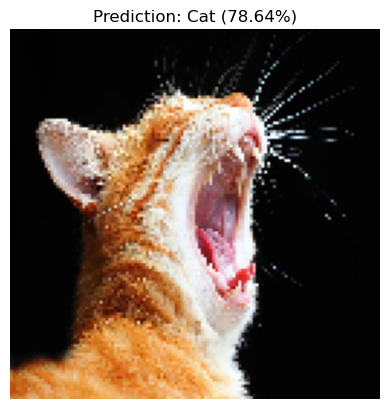

In [36]:
class ModelPrediction:
    def __init__(self, model_path, image_path):
        """Initialize the class with the model path and image path."""
        self.model_path = model_path
        self.image_path = image_path

    def load_model(self):
        """Load the trained model from the provided path."""
        self.model = load_model(self.model_path)
        print(f"Model loaded successfully from {self.model_path}.")

    def predict_image(self):
        """Load the image, preprocess it, and predict the category using the model."""
        try:
            image = load_img(self.image_path, target_size=(128, 128))  # Match the model's input size
            image_array = img_to_array(image) / 255.0  # Normalize the image
            image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

            prediction = self.model.predict(image_array)
            print(f"propability: {prediction[0][0]}")
            category = "Dog" if prediction[0] > 0.5 else "Cat"
            probability = prediction[0][0] if category == "Dog" else 1 - prediction[0][0]

            plt.imshow(image)
            plt.title(f"Prediction: {category} ({probability * 100:.2f}%)")
            plt.axis("off")
            plt.show()

        except Exception as e:
            print(f"Error predicting image: {e}")

if __name__ == "__main__":
    model_predictor = ModelPrediction(model_path="best_model.keras", image_path="test.jpg")
    model_predictor.load_model()
    model_predictor.predict_image()